In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, sys
import galsim

sys.path.insert(0,'../scripts/tools_for_VAE/')
import tools_for_VAE
from tools_for_VAE import utils, plot
from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils
from tools_for_VAE.utils import load_vae_conv, denorm, norm

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#%run ../scripts/Images_generation/cosmos_generation.py

In [3]:
training_or_test = 'test'
data_dir = '/sps/lsst/users/barcelin/data/single_galaxies/28/' + training_or_test
root = 'galaxies_isolated_20191022'

In [4]:
dfs = []
for i in range(1):
    dfs.append(pd.read_csv(os.path.join(data_dir, root+'_{}_data.csv'.format(i))))
df = dfs[0]
for df2 in dfs[1:]:
    df = df.append(df2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
redshift        10000 non-null float64
moment_sigma    10000 non-null float64
e1              10000 non-null float64
e2              10000 non-null float64
SNR             10000 non-null float64
SNR_peak        10000 non-null float64
mag             10000 non-null float64
dtypes: float64(7)
memory usage: 547.0 KB


In [7]:
df.head()

,redshift,moment_sigma,e1,e2,SNR,SNR_peak,mag
0,0.3728,2.347043,0.123473,0.551234,25.521063,78.083646,0.106139
1,0.8144,1.588691,-0.308641,0.319644,27.097584,28.553894,0.051122
2,0.3027,1.925562,-0.047280,0.186962,26.750065,31.614044,0.049189
3,0.1544,1.721385,0.013249,0.483021,27.235385,20.546669,0.034981
4,0.7710,1.846338,0.556189,-0.080457,27.696793,14.423821,0.022528


In [8]:
df.describe()

,redshift,moment_sigma,e1,e2,SNR,SNR_peak,mag
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.085139,2.028924,-0.002715,0.000819,26.647066,67.019950,0.103415
std,0.797212,0.451629,0.290762,0.291197,1.202988,158.950453,0.295221
min,0.006500,1.488476,-1.227877,-1.600182,20.509111,4.730731,0.005445
25%,0.497700,1.725604,-0.181699,-0.175791,26.184397,16.947182,0.027042
50%,0.873850,1.909301,-0.003473,-0.002153,26.987763,25.998395,0.041093
75%,1.389000,2.175293,0.173908,0.179882,27.494682,49.523470,0.074014
max,5.208000,5.651824,1.606169,1.998942,27.999770,2699.164172,7.703596


27.999769667522912

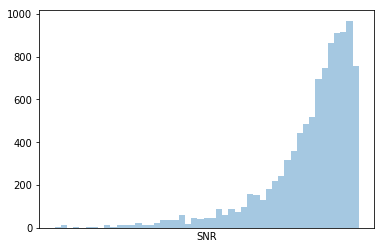

In [9]:
sns.distplot(df['SNR'], bins=np.geomspace(np.min(df['SNR']), np.max(df['SNR']), 50), kde=False)
plt.xscale('log')
plt.xlabel('SNR')
np.max(df['SNR'])

In [6]:
df['e'] = np.sqrt(df['e1']**2+df['e2']**2)

1.6878863559729709 3.1777247345658806


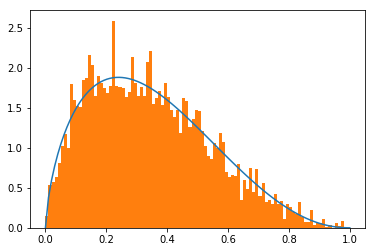

In [14]:
import scipy

e_fit = df['e'][np.logical_and(0.<df['e'], df['e']<1.)]
a, b,_,_ = scipy.stats.beta.fit(e_fit, floc=0., fscale=1.)
print(a, b)

xx = np.linspace(0,1,100)
plt.plot(xx,scipy.stats.beta.pdf(xx, a=a, b=b))
_ = plt.hist(e_fit, bins=100, range=[0,1], normed=True)

In [15]:
training_or_test = 'validation'
data_dir = '/sps/lsst/users/barcelin/data/single_galaxies/28/'+training_or_test
root = 'galaxies_isolated_20191022'
count = 0

In [30]:
def compute_e(galaxies):
    PSF = galsim.Kolmogorov(fwhm=0.65)
    r_band = 6
    bands = [0,1,2,3,4,5,6,7,8,9]
    pix_scale = 0.2

    psf_image = PSF.drawImage(nx=64, ny=64, scale=pix_scale)
    e = []
    weight = []
    error_list = []
    denormed_gal = denorm(galaxies[:,0], bands)

    for i in range(len(galaxies)):
        #print(i)
        temp_weight = 0.
        try :
            gal_image = galsim.Image(denormed_gal[i][r_band,:,:])
            gal_image.scale = pix_scale

            # Measurements of shapes
            shear_est = 'KSB'
            res = galsim.hsm.EstimateShear(gal_image, psf_image, shear_est=shear_est, strict=True)
            g = np.sqrt(res.corrected_g1**2+res.corrected_g2**2)

            if g < 1.:
                #error_list.append(i)
                #pass
                temp_weight = 1. / (scipy.stats.beta.pdf(g, a=a, b=b) + 0.1)
            else:
                error_list.append(i)
                #print('ok')
                #e.append(e_beta_in)
            #print(e_beta_in, 1 / scipy.stats.beta.pdf(e_beta_in, a=a, b=b))
        except:
            pass
        
        weight.append(temp_weight)
    return np.array(weight)#,error_list #np.array(e), count, error_list

In [31]:
weights = []
bands = [0,1,2,3,4,5,6,7,8,9]
for i in range (1):
    galaxies = np.load(os.path.join(data_dir, root+'_{}_images.npy'.format(i)), mmap_mode = 'c')
    
    # Compute e_beta
    weights = compute_e(galaxies)#, error_list
    #print(e_beta_test.shape, error_list)
    
    #norm(galaxies[:,0], bands)
    #new_galaxies = np.delete(galaxies,error_list, axis = 0)
    #print(error_list)
    #print(weights)#,e_beta_test
    #np.save(data_dir+'/cropped/'+str('weights_v2_{}.npy'.format(i+1)),np.array(weights))
    #np.save(data_dir+'/cropped/'+str('images_cropped_v2_{}.npy'.format(i+1)),new_galaxies)

[96, 466, 483, 540, 598, 743, 745, 825, 1049, 1228, 1247, 1368, 1401, 1463, 1502, 1576, 1599, 1628, 1739, 1766, 1775, 1881, 1943, 1968, 2250, 2394, 2673, 2722, 2728, 2792, 2877, 2935, 2952, 3086, 3172, 3330, 3496, 3672, 3685, 3708, 3901, 4019, 4033, 4161, 4465, 4490, 4866, 4879, 4907, 4920, 4973, 5216, 5261, 5373, 5401, 5519, 5541, 5552, 5637, 6016, 6038, 6121, 6200, 6241, 6262, 6329, 6486, 6618, 6649, 6669, 7252, 7469, 7692, 7732, 7864, 7983, 8009, 8019, 8031, 8067, 8473, 8501, 8588, 8668, 8817, 8942, 9033, 9078, 9295, 9318, 9465, 9516, 9600, 9671, 9898, 9924]


In [32]:
weights.shape

(10000,)

In [33]:
np.save(data_dir+'/cropped/'+str('weights_v2_{}.npy'.format(i+1)),weights)
#np.save(data_dir+'/cropped/'+str('images_cropped_v2_{}.npy'.format(i+1)),new_galaxies)

9.999718348599352

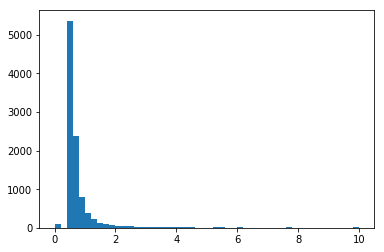

In [35]:
_ = plt.hist(weights, bins = 50)
np.max(weights)